# 7: Segmenting the detected objects in the images
In order to further augment the images, the detected objects are segmented in the images. The bounding boxes from the phrase grounding results are used to crop the objects and then segment them. Initially, GrabCut was chosen for this task due to its simplicity, but its performance was disappointing, especially on black and white images, which make up the majority of the dataset. As a result, a custom segmentation deep learning model was designed using PyTorch.

## Design of the model
The [Segmentation Models](https://github.com/qubvel/segmentation_models.pytorch)  library was used to design the model, which provides a wide range of pretrained segmentation models. The chosen architecture is a  [U-Net](https://arxiv.org/abs/1505.04597) with a [ResNet34](https://arxiv.org/abs/1512.03385) encoder, pretrained on the [Image-Net](https://www.image-net.org/index.php) dataset. This provides a good balance between inference speed and the quality of the segmentation.

## Fine-tuning
The model was fine-tuned on a subset of the [COCO-2014](https://cocodataset.org/#home) dataset, which consists of 5’000 images with bounding boxes and segmentation masks. The following process was used for fine-tuning the model:

The process of fine-tuning the model is as follows:
* The image is resized to 352x352, normalized, converted to black and white and then turned into a tensor. The bounding box is used to create a mask of the object in the image.
* The image is multiplied by the mask to remove the background and is used as the input to the model. 
* The image is used as the input to the model, and the segmentation ground truth is used as the target for the model.

The model is trained for 100 epochs, using the [Adam](https://arxiv.org/abs/1412.6980) optimizer and the [Dice Loss](https://arxiv.org/abs/1707.03237) as the loss function.

In [1]:
import pickle
import re
from itertools import compress
import json
import cv2
import matplotlib.pyplot as plt
import numpy as np
import segmentation_models_pytorch as smp
import torch
import torchvision.transforms as T
from PIL import Image
from matplotlib.patches import Polygon
from tqdm import tqdm
from matplotlib.patches import Polygon
from skimage.measure import find_contours
from torchvision.ops import nms

In [2]:
segmentation_results_dir = '../data/segmentation_results/'
segmentation_results_dir = '../docs/images/gallery/'
image_folder = '../data/BCU_database/03_resized/'

In [3]:
dataset = pickle.load(open('../data/dataset_for_segmentation.p', 'rb'))
dataset.head()

,idx,filename,caption,model,expr,conf,bbox,labels,image_id,caption_raw,caption_preprocessed,title_raw,title_preprocessed
0,1027,JOMU_32980_2k_324w.jpg,people buying sweets at the market.,GLIP,caption,"[tensor(0.8280), tensor(0.7924), tensor(0.6899...","[[tensor(178.8594), tensor(116.5122), tensor(2...","[people, people, people, people, people, peopl...",1488.0,people buying sweets at the market.,people buying sweets at the market.,"Saint Nicholas Festival Market, Place de Notre...","saint nicholas festival market, place de notre..."
1,183,CAPO_02480_2k_324w.jpg,a group of soldiers stand in front of a building.,GLIP,caption,"[tensor(0.8242), tensor(0.5884), tensor(0.5781...","[[tensor(0.8775), tensor(131.9302), tensor(81....","[soldiers, a building, a building, a building]",516.0,a group of soldiers stand in front of a building.,a group of soldiers stand in front of a building.,[Mobilization at Perolles in August 1914],[mobilization at perolles in august 1914]
2,543,JATH_26232_2k_324w.jpg,soldiers stand in front of a military vehicle.,GLIP,caption,"[tensor(0.7898), tensor(0.7305), tensor(0.6872...","[[tensor(97.0861), tensor(137.5495), tensor(14...","[soldiers, soldiers, a military vehicle, soldi...",950.0,soldiers stand in front of a military vehicle.,soldiers stand in front of a military vehicle.,"Additional service for women, Barracks de la P...","additional service for women, barracks de la p..."
3,430,JATH_10616_2k_324w.jpg,women walking down a street.,GLIP,caption,"[tensor(0.6900), tensor(0.6777), tensor(0.6676...","[[tensor(125.4207), tensor(111.6184), tensor(1...","[women, women, women, a street, women]",836.0,women walking down a street.,women walking down a street.,Procession on the route to the Alps during a w...,procession on the route to the alps during a w...
4,408,HAWI_01023_2k_324w.jpg,a photograph of a large tropical cyclone.,GLIP,caption,[tensor(0.7263)],"[[tensor(4.5861), tensor(13.1419), tensor(318....",[a large tropical cyclone],814.0,a photograph of a large tropical cyclone.,a a large tropical cyclone.,Tornado over Lake Morat,tornado over lake morat


### The dataset class

In [4]:
class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        df_dataset,
        transforms=None,
        transforms_mask=None,
        images_folder=None,
        desired_size=352
    ):
        self.transforms = transforms
        self.transforms_mask = transforms_mask
        self.df_dataset = df_dataset
        self.images_folder = images_folder
        self.desired_size = desired_size

    def __getitem__(self, idx):
        data = self.df_dataset.loc[idx].copy()
        img_path = self.images_folder + data['filename']
        pilimg = Image.open(img_path).convert("RGB")
        img = np.array(pilimg)
        mask = np.zeros((len(data['bbox']), img.shape[0], img.shape[1]))

        old_size = img.shape[:2]
        ratio = float(self.desired_size) / max(old_size)
        new_size = tuple([int(x * ratio) for x in old_size])
        img = cv2.resize(img, (new_size[1], new_size[0]))

        delta_w = self.desired_size - new_size[1]
        delta_h = self.desired_size - new_size[0]
        top, bottom = delta_h // 2, delta_h - (delta_h // 2)
        left, right = delta_w // 2, delta_w - (delta_w // 2)

        color = [0, 0, 0]
        img = cv2.copyMakeBorder(
            img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color
        )
        new_mask = []
        if len(data['conf']) == 0:
            return {
            'original_shape': old_size,
            'input': None,
            'mask': None,
            'data': data,
            }
        for i, box in enumerate(data['bbox']):
            box[box < 0] = 0
            box = box.int()
            mask[i, box[1] : box[3], box[0] : box[2]] = 1
            new_mask.append(
                cv2.copyMakeBorder(
                    cv2.resize(mask[i], (new_size[1], new_size[0])),
                    top,
                    bottom,
                    left,
                    right,
                    cv2.BORDER_CONSTANT,
                    value=color,
                )
            )
        mask = np.array(new_mask)

        if self.transforms_mask is not None:
            transformed_mask = []
            for i, mask_ in enumerate(mask):
                transformed_mask.append(self.transforms_mask(mask_))
            mask = torch.stack(transformed_mask)
        if self.transforms is not None:
            img = self.transforms(img)

        filtered_segmentation = torch.zeros((len(data['bbox']), 3, img.shape[1], img.shape[2]))
        for i, mask_ in enumerate(mask):
            filtered_segmentation[i] = img * mask_

        return {
            'original_shape': old_size,
            'input': filtered_segmentation,
            'mask': mask,
            'data': data,
        }

    def __len__(self):
        return len(self.df_dataset)

In [5]:
transform_test = T.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
transform_mask_test = T.Compose([
    T.ToTensor(),
])
dataset_test = SegmentationDataset(dataset, images_folder=image_folder, transforms=transform_test, transforms_mask = transform_mask_test)

### Plotting functions

In [15]:
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933], [0,0,0]]


def process_word(word):
    """Processes a word by removing special characters and spaces.

    Args:
        word (str): The word to process.

    Returns:
        str: The processed word.
    """
    return word.replace('.','').replace(' ', '').replace(')','').replace('(','').replace('-','').lower()

def apply_mask(image, mask, color, ax, alpha=0.3):
    """Apply the given mask to the image.

    Args:
        image (numpy.ndarray): The image to apply the mask to.
        mask (numpy.ndarray): The mask to apply to the image.
        color (list or tuple): The color to use for the mask.
        alpha (float, optional): The transparency of the mask. Default is 0.3.

    Returns:
        numpy.ndarray: The image with the applied mask.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    padded_mask = np.zeros((mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
    padded_mask[1:-1, 1:-1] = mask
    contours = find_contours(padded_mask, 0.5)
    for verts in contours:
        verts = np.fliplr(verts) - 1
        p = Polygon(verts, facecolor="none", edgecolor=color)
        ax.add_patch(p)
    return image

def get_color(label, set_label):
    for i, elem in enumerate(set_label):
        if process_word(elem) == process_word(label):
            return i
    return 6

def color_text(color, text, label, c):
    """Color specified label in text."""
    # Find label in text and change its color
    index = [i for i, word in enumerate(text) if word.lower() == label.lower()]
    if index:
        color[index[0]] = c
    else:
        index = [i for i, word in enumerate(text) if process_word(word) == process_word(label)]
        if index:
            color[index[0]] = c
        else:
            # Split text and label into subwords
            sub_text = [word.split() for word in text]
            sub_text = [word for sublist in sub_text for word in sublist]
            sub_label = label.split()
            # Find subwords in text
            index = [i for sub_word in sub_label for i, word in enumerate(sub_text) if word.lower() == sub_word.lower()]
            # Find words containing index subwords
            final_index = [i for index_ in index for i, word in enumerate(text) if word.find(sub_text[index_]) > -1]
            if final_index:
                color[final_index[0]] = c
            else:
                print(f'No match for {label} in {text}')
    return color

def plot_results(ax, pil_img, results, expr, masks=None, conf=0.7):
    # Return early if no results
    if results is None:
        return ax

    # Filter results by confidence threshold
    keep = results['conf'] > conf
    scores = results['conf'][keep]
    boxes = results['bbox'][keep]
    labels = [label for i, label in enumerate(results['labels']) if keep[i]]
    set_label = set(labels)
    if masks is not None:
        masks = masks[keep]
    else:
        masks = [None] * len(boxes)
    
    np_image = np.array(pil_img)


    labels = [x for _,x in sorted(zip(boxes[:,0],labels))]
    scores = [x for _,x in sorted(zip(boxes[:,0],scores))]
    masks = [x for _,x in sorted(zip(boxes[:,0],masks),key=lambda x: x[0])]
    boxes = [x for _,x in sorted(zip(boxes[:,0],boxes),key=lambda x: x[0])]
    set_label = [label.replace('( ', '(').replace(' )',')') for label in set_label]

    text = [expr for expr in re.split('(' + ('|').join(set_label).replace('(','\(').replace(')','\)') + ')', expr, flags=re.IGNORECASE) if expr.strip()]
    colors = [[0,0,0] for word in text]

    for s, (xmin, ymin, xmax, ymax), l, mask in zip(scores, boxes, labels, masks):
        if mask is None:
            continue
        # find the color of the label
        c = COLORS[get_color(l, set_label)]
        # color the label in text
        colors = color_text(colors, text, l, c)
        # apply mask to image
        np_image = apply_mask(np_image, mask, c, ax)



    ax.imshow(np_image)
    ax.set_xticks([])
    ax.set_yticks([])
    return {'text': text, 'colors': colors}

### The segmentation model

In [16]:
class Model(object):
    def __init__(self, path):
        self.model = torch.load(path)
        self.model = self.model.cuda()
        self.model.eval()
    
    @torch.no_grad()
    def inference(self, data):
        """Performs inference on the given data.

        Args:
            data (dict): A dictionary containing the data to perform inference on.
                The dictionary should have the following keys:
                - 'mask': A torch.Tensor of shape (num_masks, height, width) containing the masks for the input image.
                - 'input': A torch.Tensor of shape (num_masks, 3, height, width) containing the input image.
                - 'original_shape': A tuple of (height, width) representing the original shape of the input image.

        Returns:
            tuple: A tuple containing the original data and the filtered_segmentation of the model.
                The filtered_segmentation is a torch.Tensor of shape (num_masks, height, width) containing the segmentation masks.
        """

        # Return early if mask is not present
        if data['mask'] is None:
            return data, None

        self.model.eval()
        predictions = []

        # Compute predictions for each mask
        for img in data['input']:
            prediction = self.model(img[None,:,:,:].cuda()).cpu().detach().numpy()[0]
            predictions.append(prediction)

        filtered_segmentation = []
        bboxes = []

        # Apply mask to prediction in order to filter out noise outside of the mask
        for mask, prediction in zip(data['mask'], predictions):
            filtered_segmentation.append(mask * prediction)
            bboxes.append(self.get_bbox_from_mask(mask[0]))

        filtered_segmentation = torch.cat(filtered_segmentation)

        # Resize filtered_segmentation to original image size
        if data['original_shape'][0] > data['original_shape'][1]:
            resize = T.Resize(data['original_shape'][0], interpolation=T.InterpolationMode.NEAREST)
            resized_segmentation = resize(filtered_segmentation)
            resized_segmentation = resized_segmentation[:,:,(resized_segmentation.shape[2] - data['original_shape'][1]) // 2:
                                (resized_segmentation.shape[2] - data['original_shape'][1]) // 2 + data['original_shape'][1]]
        else:
            resize = T.Resize(data['original_shape'][1], interpolation=T.InterpolationMode.NEAREST)
            resized_segmentation = resize(filtered_segmentation)
            resized_segmentation = resized_segmentation[:, (resized_segmentation.shape[1]  - data['original_shape'][0]) // 2:
                                (resized_segmentation.shape[1]  - data['original_shape'][0]) // 2 + data['original_shape'][0]]

        return resized_segmentation

    def get_bbox_from_mask(self, mask, mask_value = 1):
        mask[mask<0] = 0
        if mask_value is None:
            seg = np.where(mask != 0)
        else:
            seg = np.where(mask == mask_value)
        if seg[0].size <= 0 or seg[1].size <= 0:
            return np.zeros((4,), dtype = int)
        min_x = np.min(seg[1])
        min_y = np.min(seg[0])
        max_x = np.max(seg[1])
        max_y = np.max(seg[0])

        return [min_x, min_y, max_x, max_y]


model = Model('../model/model_segmentation.pth')

### Runs the model on the images

  0%|          | 0/1454 [00:00<?, ?it/s]

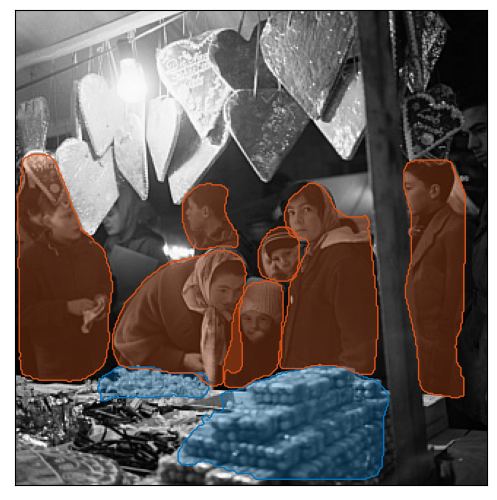

  0%|          | 1/1454 [00:00<07:41,  3.15it/s]

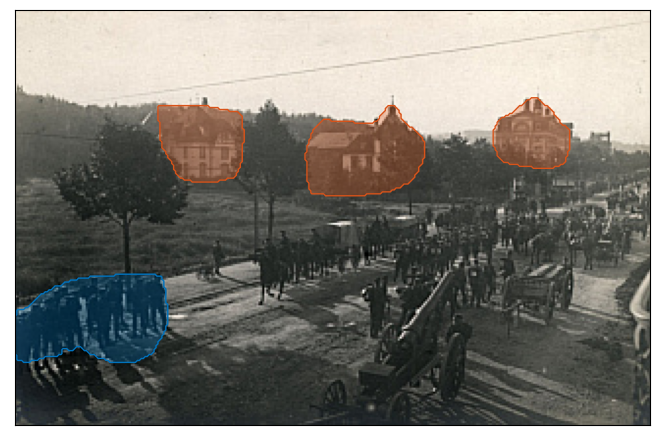

  0%|          | 2/1454 [00:00<06:41,  3.62it/s]

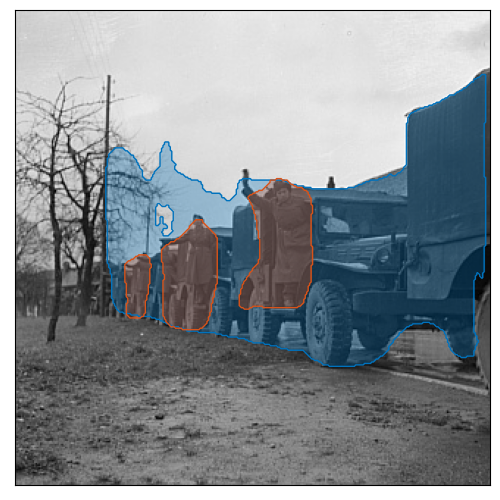

  0%|          | 3/1454 [00:00<06:06,  3.96it/s]

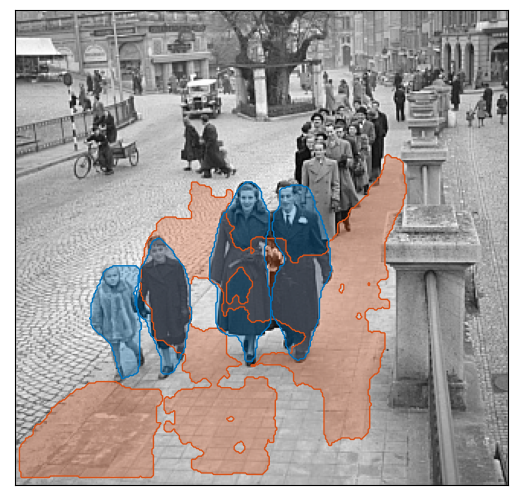

  0%|          | 4/1454 [00:01<06:16,  3.85it/s]

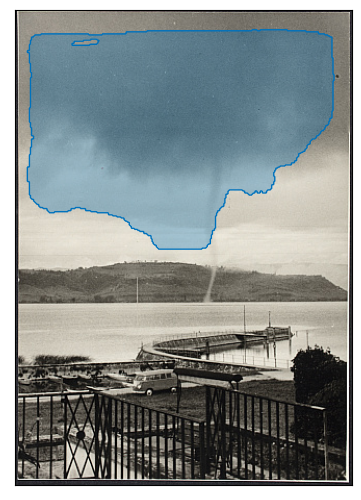

  0%|          | 5/1454 [00:01<05:19,  4.53it/s]

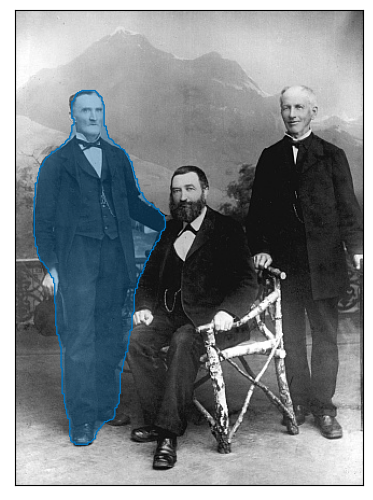

  0%|          | 6/1454 [00:01<04:41,  5.15it/s]

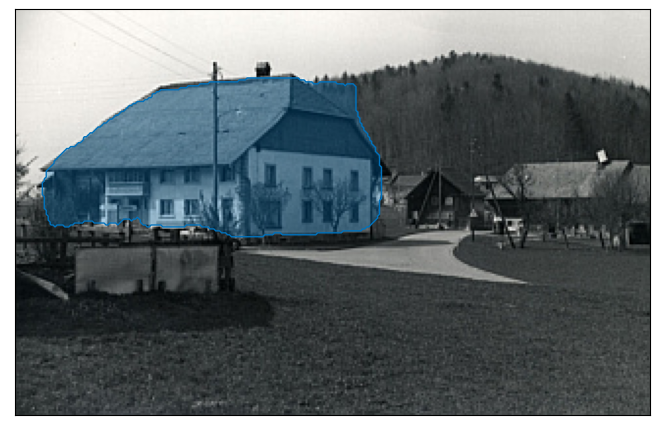

  0%|          | 6/1454 [00:01<06:09,  3.92it/s]


In [17]:
figure = plt.figure()
from time import time
titles = dict()

for i, data in enumerate(tqdm(dataset_test)):
    segmentation_masks = model.inference(data)
    if segmentation_masks is not None:
        img = np.array(Image.open(image_folder + data['data']['filename']).convert("RGB"))

        ax = plt.gca()
        title = plot_results(ax, img.astype(int), data['data'], expr=data['data']['caption'], masks=segmentation_masks, conf=0)
        titles[data['data']['filename']] = title

        plt.tight_layout(pad=0)
        plt.show()
        if i > 5:
            break
        # Save the plot to a file

        # plt.savefig(segmentation_results_dir + result['data']['filename'], bbox_inches="tight")
        # plt.cla()
    

### Transforms the colored captions to HTML code

In [31]:
captions = dict()

# Iterate over the items in the JSON object
for image, image_data in titles.items():
    # Get the text and color data for the image
    text = image_data["text"]
    colors = image_data["colors"]

    # Create an empty list to store the HTML text
    html_text = []

    # Iterate over the text and color data
    for i in range(len(text)):
        # Convert the RGB color values to hexadecimal
        color = "#{:02x}{:02x}{:02x}".format(
            int(colors[i][0] * 255),
            int(colors[i][1] * 255),
            int(colors[i][2] * 255)
        )

        # Add the text and color to the HTML text list
        html_text.append(f'<span style="color: {color}">{text[i]}</span>')

    # Join the HTML text list into a single string
    html_text = "".join(html_text)
    captions[image] = html_text
    # Print the HTML text for the image

In [32]:
# save captions
with open('../docs/_data/captions.json', 'w') as f:
    json.dump(captions, f)